In [1]:
def ComputeMyTaskNumber(your_name):
    return 1 + hash(your_name) % 21

ComputeMyTaskNumber('Salikhova_Kariya')

16

## Задача: Реализация алгоритма iGBRT с квадратичной фунцией потерь.
http://proceedings.mlr.press/v14/mohan11a/mohan11a.pdf

In [2]:
import numpy as np
import matplotlib.pyplot as plt

### Подготовка данных

In [3]:
max_idx = 0
with open("reg.train.txt") as f:
    for line in f:
        items = line.split()
        items = items[1:]
        for item in items:
            idx, value = item.split(':')
            if int(idx) > max_idx:
                max_idx = int(idx)
        
with open("reg.test.txt") as f:
    for line in f:
        items = line.split()
        items = items[1:]
        for item in items:
            idx, value = item.split(':')
            if int(idx) > max_idx:
                max_idx = int(idx)
max_idx

245

In [74]:
y_train = []
X_train = []
fillna_val = 5
with open("reg.train.txt") as f:
    for line in f:
        features = np.array((max_idx+1) * [fillna_val], dtype=float)
        items = line.split()
        y_train.append(float(items[0]))
        items = items[1:]
        for item in items:
            idx, value = item.split(':')
            features[int(idx)] = float(value)
        X_train.append(features)
        
y_test = []
X_test = []
with open("reg.test.txt") as f:
    for line in f:
        features = np.array((max_idx+1) * [fillna_val], dtype=float)
        items = line.split()
        y_test.append(float(items[0]))
        items = items[1:]
        for item in items:
            idx, value = item.split(':')
            features[int(idx)] = float(value)
        X_test.append(features)        

In [75]:
y_train = np.array(y_train)
y_test = np.array(y_test)
X_train = np.array(X_train)
X_test = np.array(X_test)

### Реализация

In [6]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

import time

from sklearn.metrics import mean_squared_error

В каждом узле хотим минимизировать меру неопределенности в потомках:
$$
L(N) = \frac{1}{N}\sum\limits_{i=1}^{N}(y_i - \overline{y}_N) = \frac{1}{N}\left(\sum\limits_{i=1}^{N}y_i^2 - 2\overline{y}_N\sum\limits_{i=1}^{N}y_i + N\overline{y}_N^2\right) = \frac{1}{N}\left(\sum\limits_{i=1}^{N}y_i^2 - 2\frac{\left(\sum\limits_{i=1}^{N}y_i\right)^2}{N} + \frac{\left(\sum\limits_{i=1}^{N}y_i\right)^2}{N}\right) = \frac{1}{N}\left(\sum\limits_{i=1}^{N}y_i^2 - \frac{\left(\sum\limits_{i=1}^{N}y_i\right)^2}{N}\right) \rightarrow \min\limits_N ,
$$
где $N$ - номер объекта, в отсортированном по значению признака массиве.

In [7]:
class My_DecisionTree:
    NON_LEAF_TYPE = 0
    LEAF_TYPE = 1
    
    def __init__(self, max_depth=None, min_samples_split=2, min_samples_leaf=1):
        self.tree = dict()
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        
    def get_params(self, deep=True):
        return {
            "max_depth": self.max_depth,
            "min_samples_split": self.min_samples_split,
            "min_samples_leaf": self.min_samples_leaf
        }      

    def sort_samples(self, x, y):
        sorted_idx = x.argsort(axis=0)
        return np.sort(x, axis=0), y[sorted_idx]
    
    def div_samples(self, x, y, feature_id, threshold):
        left_mask = x[:, feature_id] <= threshold
        right_mask = ~left_mask
        return x[left_mask], x[right_mask], y[left_mask], y[right_mask]

    def fit_node(self, x, y, node_id, depth):
        if (depth == self.max_depth) or (x.shape[0] < self.min_samples_split):
            self.tree[node_id] = self.LEAF_TYPE, np.mean(y)
            return
        
        sorted_x, sorted_y = self.sort_samples(x, y)
        #каждый столбец i sorted_y - упорядочен в порядке возрастания значений i-ой фичи
        lengths = np.array(range(sorted_x.shape[0] + 1)[1:]).reshape(-1, 1)
        #loss1 отвечает за то, чтобы минимум достигался в левом поддереве
        loss1 = np.cumsum(sorted_y ** 2, axis=0) - np.cumsum(sorted_y, axis=0) ** 2/lengths
                  
        #loss2 отвечает за то, чтобы минимум достигался в правом поддереве
        loss2 = np.cumsum(sorted_y[::-1] ** 2, axis=0)[::-1] -\
        (np.cumsum(sorted_y[::-1], axis=0) ** 2)[::-1]/lengths[::-1]
        loss1[:-1] += loss2[1:]
        loss = loss1
        
        shifted_x = np.roll(sorted_x, axis=0, shift=-1)
        loss[np.isclose(sorted_x, shifted_x, atol=1e-3)] = np.nan 
        try:
            argmin = np.nanargmin(loss)
        except ValueError:
            #окажемся здесь, если все фичи близки друг к другу
            self.tree[node_id] = (self.LEAF_TYPE, np.mean(y))
            return
        
        #номер строки
        best_sample_idx = argmin // loss.shape[1]
        #номер столбца
        best_feature_idx = argmin - best_sample_idx*loss.shape[1]
        
        threshold = sorted_x[best_sample_idx, best_feature_idx]
        x_l, x_r, y_l, y_r = self.div_samples(x, y, best_feature_idx, threshold)
        
        if x_l.shape[0] < self.min_samples_leaf or x_l.shape[0] < self.min_samples_leaf:
            self.tree[node_id] = (self.LEAF_TYPE, np.mean(y))
        else:
            self.tree[node_id] = (self.NON_LEAF_TYPE, best_feature_idx, threshold)
            self.fit_node(x_l, y_l, 2*node_id + 1, depth + 1)
            self.fit_node(x_r, y_r, 2*node_id + 2, depth + 1)

    def fit(self, x, y):
        self.features = np.arange(x.shape[1])
        self.fit_node(x[:, self.features], y, 0, 0)
        return self

    def predict_node(self, x, node_id):
        node = self.tree[node_id]
        res = np.zeros(x.shape[0])
        if node[0] == self.__class__.NON_LEAF_TYPE:
            node_type, best_feature_idx, threshold = node
            idx = np.where(x[:, best_feature_idx] <= threshold)
            res[idx] = self.predict_node(x[idx], 2*node_id + 1)
            idx = np.where(x[:, best_feature_idx] > threshold)
            res[idx] = self.predict_node(x[idx], 2*node_id + 2)
            return res
        return np.array([node[1]]*x.shape[0])
            
    def predict(self, X):
        x = X[:, self.features]
        res = self.predict_node(X, 0)
        return res

In [8]:
my_clf = My_DecisionTree(max_depth=10)
clf = DecisionTreeRegressor(max_depth=10)

In [9]:
start = time.process_time()
my_clf.fit(X_train, y_train)
print('Process time: {0} c'.format(time.process_time() - start))

Process time: 2.328125 c


In [10]:
start = time.process_time()
clf.fit(X_train, y_train)
print('Process time: {0} c'.format(time.process_time() - start))

Process time: 0.453125 c


In [11]:
my_pred = my_clf.predict(X_test)
pred = clf.predict(X_test)
print("My DecisionTree: MSE = {}".format(mean_squared_error(y_test, my_pred)))
print("Sklearn DecisionTreeRegressor: MSE = {}".format(mean_squared_error(y_test, pred)))

My DecisionTree: MSE = 0.9550815177642769
Sklearn DecisionTreeRegressor: MSE = 1.0448639108701767


In [12]:
class My_RandomForest:
    def __init__(self, n_estimators=20, max_depth=None, min_samples_split=2, min_samples_leaf = 1):
        self.n_estimators = int(n_estimators)
        self.max_depth = max_depth
        self.min_samples_split = int(min_samples_split)
        self.min_samples_leaf = min_samples_leaf
        self.models = []
        
    def get_params(self, deep=True):
        return {
            "n_estimators": self.n_estimators,
            "max_depth": self.max_depth,
            "min_samples_split": self.min_samples_split,
            "min_samples_leaf": self.min_samples_leaf
        }  
            
    def fit(self, X, y):
        for i in range(self.n_estimators):
            tree = My_DecisionTree(min_samples_split=self.min_samples_split,
                                      max_depth=self.max_depth, min_samples_leaf=self.min_samples_leaf)
            idx = np.random.randint(0, X.shape[0], X.shape[0]) # 1 x X.shape[0]
            tree.fit(X[idx], y[idx])
            self.models.append(tree)
        return self

    def predict(self, X):
        res = np.zeros(X.shape[0])
        for i in range(self.n_estimators):
            res += self.models[i].predict(X)
        return res/self.n_estimators

In [13]:
my_clf = My_RandomForest(max_depth=5)
clf = RandomForestRegressor(max_depth=5)

In [14]:
start = time.process_time()
my_clf.fit(X_train, y_train)
print('Process time: {0} c'.format(time.process_time() - start))

Process time: 28.578125 c


In [15]:
start = time.process_time()
clf.fit(X_train, y_train)
print('Process time: {0} c'.format(time.process_time() - start))

Process time: 14.375 c


In [16]:
my_pred = my_clf.predict(X_test)
pred = clf.predict(X_test)
print("My RandomForest: MSE = {}".format(mean_squared_error(y_test, my_pred)))
print("Sklearn RandomForestRegressor: MSE = {}".format(mean_squared_error(y_test, pred)))

My RandomForest: MSE = 0.7846311090628958
Sklearn RandomForestRegressor: MSE = 0.786535221919431


#### Идея iGBRT:
- Результат градиентного спуска во многом зависит от начальной инициализации: в зависимости от инициализации можем найти глобальный минимум, или же провалиться в локальный.
- Поэтому используем для инициализации градиентного спуска результат модели RandomForest, так как RF устойчива к переобучению (это важно для того, чтобы не загубить градиентный бустинг на первом же шаге) и не требует настройки параметров.

Минимизируем:
$$
L(y, f) = (y-f)^2 \rightarrow \min\limits_f.
$$
$$
\frac{dL}{df} = -2(y-f).
$$

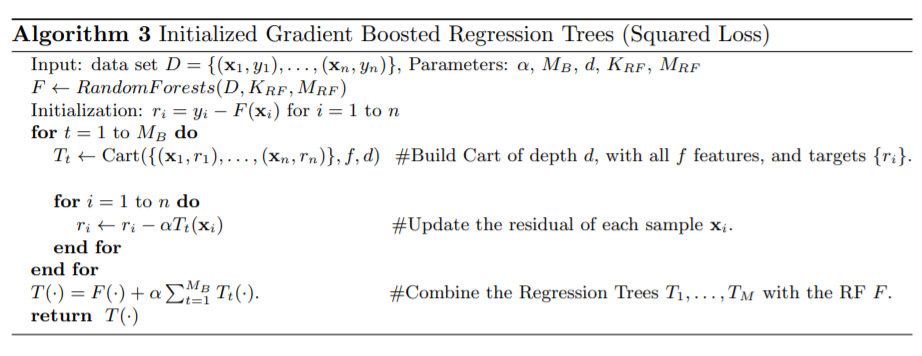

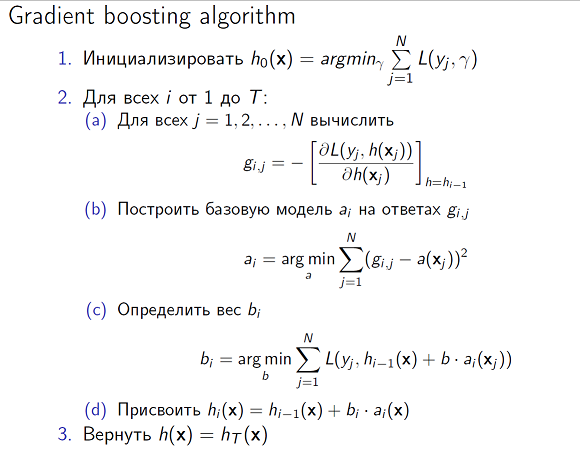

In [91]:
from tqdm import tqdm

class iGBRT:
    def __init__(self, learning_rate=0.1, n_estimators=20, n_estimators_for_rf=60,
                 min_samples_split=2, max_depth=3, max_features=None):
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.n_estimators_for_rf = n_estimators_for_rf
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.max_features = max_features
        self.models = []
        self.lr = []
        
    def get_params(self, deep=True):
        return {
            "learning_rate": self.learning_rate,
            "n_estimators": self.n_estimators,
            "n_estimators_for_rf": n_estimators_for_rf,
            "min_samples_split": self.min_samples_split,
            "max_depth": self.max_depth,
            "max_features": self.max_features
        }
    
    def search_k(self, y, pred, y_pred=None):
        k = np.arange(-2, 2, 0.01)
        len_k = len(k)
        rep_k = np.repeat(k, len(pred)).reshape(-1, len(pred)).T
        pred = np.repeat(pred, len_k).reshape(-1, len_k)
        y_pred = np.repeat(y_pred, len_k).reshape(-1, len_k)
        y = np.repeat(y, len_k).reshape(-1, len_k)
        
        L = np.mean((y - (y_pred + rep_k*pred))**2, axis=0)
        argmin = np.argmin(L)
        return k[argmin]
    
    def fit(self, X, y):
        model_0 = My_RandomForest(n_estimators=self.n_estimators_for_rf, max_depth=self.max_depth,
                                               min_samples_split=self.min_samples_split)
        model_0.fit(X, y)
        y_pred = model_0.predict(X)
        self.models.append(model_0)
        for t in tqdm(range(self.n_estimators)[1:]):
            # r = -dL
            r = y - y_pred
            model_t = My_DecisionTree(max_depth=self.max_depth,
                                      min_samples_split=self.min_samples_split)
            model_t.fit(X, r)
            # model_t аппроксимирует антиградиент L
            pred = model_t.predict(X)
            cur_k = self.search_k(y, pred, y_pred)
            # self.learning_rate - shrinkage
            y_pred += cur_k * self.learning_rate * pred
            self.models.append(model_t)
            self.lr.append(cur_k*self.learning_rate)
    
    def predict(self, X):
        res = self.models[0].predict(X)
        for i, model in enumerate(self.models[1:]):
            model_res = self.lr[i] * model.predict(X)
            res += model_res
        return res
    
    def staged_predict(self, X):
        res = self.models[0].predict(X)
        yield res
        for i, model in enumerate(self.models[1:]):
            res += self.lr[i] * model.predict(X)
            yield res

#### Подбор параметра: количество деревьев в начальном Random Forest

In [21]:
T = 50
n = [10, 20, 30, 40, 50, 60, 70]
train_loss = []
test_loss = []
test = []
train = []
for num_rf in tqdm(n):
    my_clf = iGBRT(n_estimators=T, n_estimators_for_rf=num_rf)
    my_clf.fit(X_train, y_train)
    
    my_pred_train = my_clf.predict(X_train)
    train_loss.append(mean_squared_error(y_train, my_pred_train))
    my_train_loss = []
    for my_res in my_clf.staged_predict(X_train):
        my_train_loss.append(mean_squared_error(y_train, my_res))
    train.append(my_train_loss)
    
    my_pred_test = my_clf.predict(X_test)
    test_loss.append(mean_squared_error(y_test, my_pred_test))
    my_test_loss = []
    for my_res in my_clf.staged_predict(X_test):
        my_test_loss.append(mean_squared_error(y_test, my_res))
    test.append(my_test_loss)

100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [17:31<00:00, 150.27s/it]


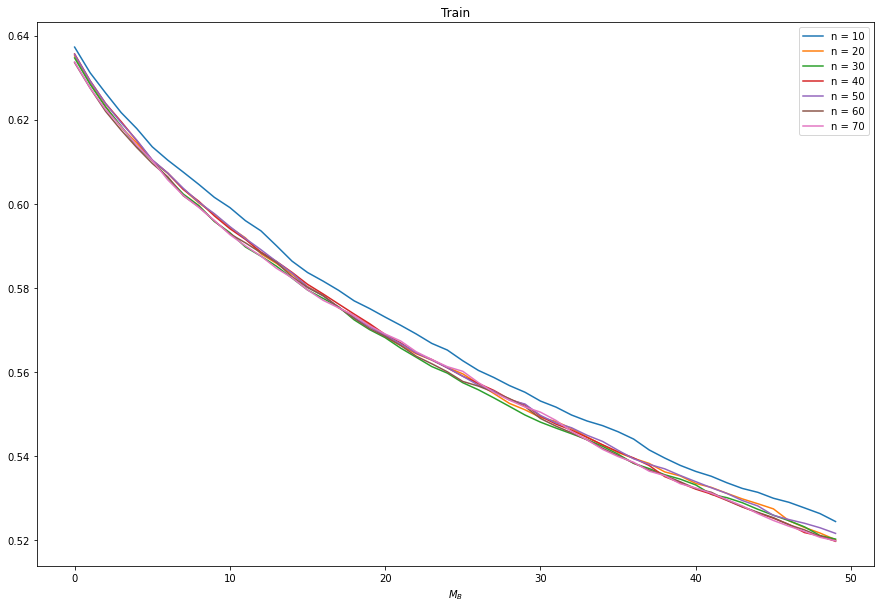

In [25]:
plt.figure(figsize=(15, 10))
for i in range(len(n)):
    plt.plot(train[i], label = 'n = {0}'.format(n[i]))
plt.title('Train')
plt.xlabel('$M_B$')
plt.legend()
plt.show()

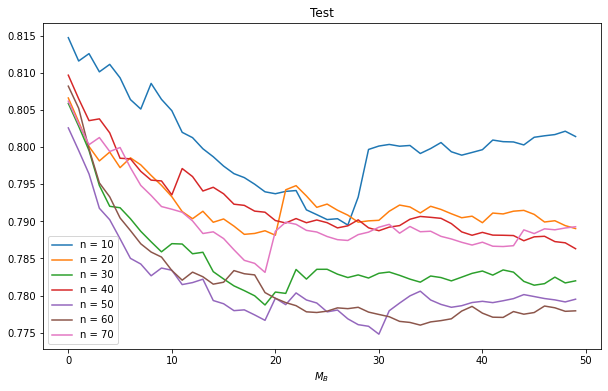

In [26]:
plt.figure(figsize=(10, 6))
for i in range(len(n)):
    plt.plot(test[i], label = 'n = {0}'.format(n[i]))
plt.title('Test')
plt.xlabel('$M_B$')
plt.legend()
plt.show()

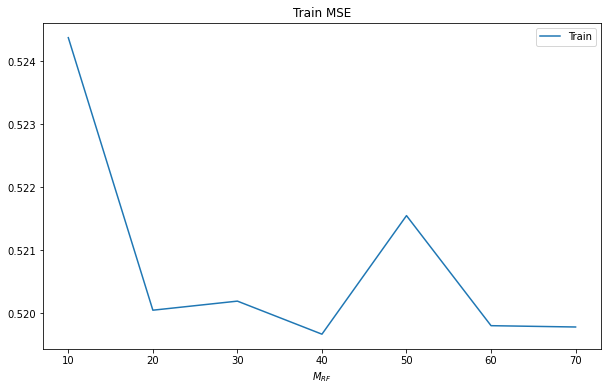

In [27]:
plt.figure(figsize=(10, 6))
plt.title('Train MSE')
plt.plot(n, train_loss, label='Train')
plt.xlabel('$M_{RF}$')
plt.legend()
plt.show()

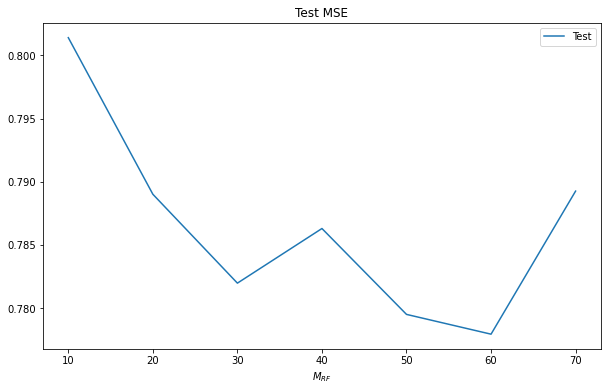

In [28]:
plt.figure(figsize=(10, 6))
plt.title('Test MSE')
plt.plot(n, test_loss, label='Test')
plt.xlabel('$M_{RF}$')
plt.legend()
plt.show()

___Лучшие кандидаты___: n_estimators_for_rf = 60

### Результаты

In [92]:
T = 300
my_clf = iGBRT(n_estimators=T)
clf = GradientBoostingRegressor(n_estimators=T, criterion='mse')

In [93]:
start = time.process_time()
my_clf.fit(X_train, y_train)
print('Process time: {0} c'.format(time.process_time() - start))

100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [05:20<00:00,  1.07s/it]

Process time: 371.921875 c


In [94]:
start = time.process_time()
clf.fit(X_train, y_train)
print('Process time: {0} c'.format(time.process_time() - start))

Process time: 53.171875 c


In [95]:
my_pred_train = my_clf.predict(X_train)
pred_train = clf.predict(X_train)
print('Train iGBRT: MSE = {}'.format(mean_squared_error(y_train, my_pred_train)))
print('Train Sklearn GBR: MSE = {}'.format(mean_squared_error(y_train, pred_train)))
my_train_loss = []
train_loss = []
for my_res in my_clf.staged_predict(X_train):
    my_train_loss.append(mean_squared_error(y_train, my_res))
for res in clf.staged_predict(X_train):
    train_loss.append(mean_squared_error(y_train, res))

Train iGBRT: MSE = 0.3464940443626165
Train Sklearn GBR: MSE = 0.34249010103782557


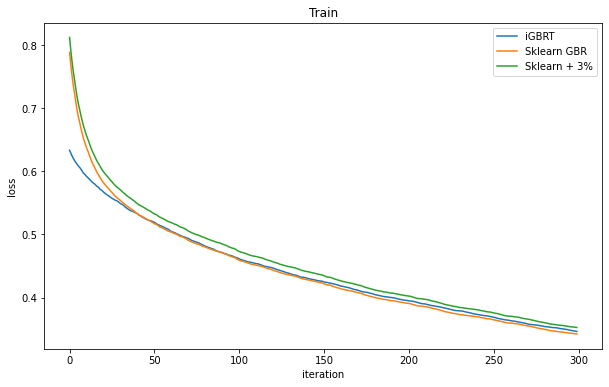

In [96]:
plt.figure(figsize=(10, 6))
plt.title('Train')
plt.plot(range(T), my_train_loss, label='iGBRT')
plt.plot(range(T), train_loss, label='Sklearn GBR')
plt.plot(range(T), np.array([1.03]*len(train_loss))*train_loss, label='Sklearn + 3%')
plt.legend()
plt.xlabel('iteration')
plt.ylabel('loss')
plt.show()

In [98]:
my_pred_test = my_clf.predict(X_test)
pred_test = clf.predict(X_test)
print('Test iGBRT: MSE = {}'.format(mean_squared_error(y_test, my_pred_test)))
print('Test Sklearn GBR: MSE = {}'.format(mean_squared_error(y_test, pred_test)))
my_test_loss = []
test_loss = []
for my_res in my_clf.staged_predict(X_test):
    my_test_loss.append(mean_squared_error(y_test, my_res))
for res in clf.staged_predict(X_test):
    test_loss.append(mean_squared_error(y_test, res))

Test iGBRT: MSE = 0.77517028344618
Test Sklearn GBR: MSE = 0.7758346718485927


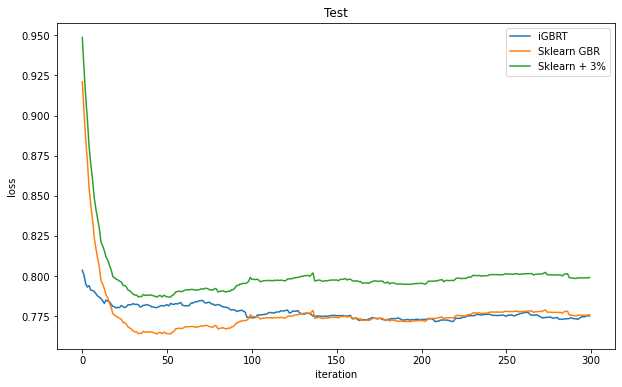

In [99]:
plt.figure(figsize=(10, 6))
plt.title('Test')
plt.plot(range(T), my_test_loss, label='iGBRT')
plt.plot(range(T), test_loss, label='Sklearn GBR')
plt.plot(range(T), np.array([1.03]*len(test_loss))*test_loss, label='Sklearn + 3%')
plt.legend()
plt.xlabel('iteration')
plt.ylabel('loss')
plt.show()